# Author: Sean Smith
https://github.com/ssmith21

## Rings + 1.5 = abalone age in years

####  In this notebook, I only refer to the number of rings for each abalone however the age of an abalone is easily derived from the number of rings.

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from heapq import nsmallest, nlargest
import seaborn as sns

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, Reshape, LSTM
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.backend import clear_session
from keras.preprocessing.image import ImageDataGenerator
from kerastuner.tuners import RandomSearch

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers

import tensorflow as tf
print(f"Number of GPUs available : {len(tf.config.experimental.list_physical_devices('GPU'))} ")

dataframe = pd.read_csv('abalone.data.csv')
dataframe.columns = [
    'Sex',
    'Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Shucked weight',
    'Viscera weight',
    'Shell weight',
    'Rings'
]

df = dataframe.copy(deep=True) # Make a deep copy so as not to modify the origional dataset
print(df.shape)
print(df[:5])

Number of GPUs available : 1 
(4176, 9)
  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
1   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
2   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
3   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   
4   I   0.425     0.300   0.095        0.3515          0.1410          0.0775   

   Shell weight  Rings  
0         0.070      7  
1         0.210      9  
2         0.155     10  
3         0.055      7  
4         0.120      8  


# Renaming the columns, since names were missing.

Sex, Length, Diameter, Height, Whole weight, Shucked weight, Viscera weight, Shell weight, Rings

In [198]:
df.columns = [
    'Sex',
    'Length',
    'Diameter',
    'Height',
    'Whole weight',
    'Shucked weight',
    'Viscera weight',
    'Shell weight',
    'Rings'
]
print(df[:5])

  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
1   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
2   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
3   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   
4   I   0.425     0.300   0.095        0.3515          0.1410          0.0775   

   Shell weight  Rings  
0         0.070      7  
1         0.210      9  
2         0.155     10  
3         0.055      7  
4         0.120      8  


# Exploring the dataset
### Basic exploration

In [199]:
print(f'Shape of dataset: {df.shape}\n')
print(f'First column description:\n{df.iloc[:,0].value_counts()}\n')

print('No blanks or nulls or NaNs in data:')
for i in range(1,9):
    print(f'Number of NaNs for column {i+1} : {len(df) - df.iloc[:,i].count()}')

Shape of dataset: (4176, 9)

First column description:
M    1527
I    1342
F    1307
Name: Sex, dtype: int64

No blanks or nulls or NaNs in data:
Number of NaNs for column 2 : 0
Number of NaNs for column 3 : 0
Number of NaNs for column 4 : 0
Number of NaNs for column 5 : 0
Number of NaNs for column 6 : 0
Number of NaNs for column 7 : 0
Number of NaNs for column 8 : 0
Number of NaNs for column 9 : 0


### Checking out the values

In [200]:
for i in range(1,9):
    col = df.iloc[:,i]
    col_name = df.columns[i]
    print(f'Data for {col_name}')
    print(f'5 largest values : {nlargest(5, col)}')
    print(f'5 smallest values : {nsmallest(5, col)}')
    print(f'Average value: {sum(col)/len(col)}')
    print('\n')

Data for Length
5 largest values : [0.815, 0.8, 0.78, 0.78, 0.775]
5 smallest values : [0.075, 0.11, 0.13, 0.13, 0.135]
Average value: 0.5240086206896557


Data for Diameter
5 largest values : [0.65, 0.63, 0.63, 0.63, 0.625]
5 smallest values : [0.055, 0.09, 0.095, 0.1, 0.1]
Average value: 0.40789152298850717


Data for Height
5 largest values : [1.13, 0.515, 0.25, 0.25, 0.25]
5 smallest values : [0.0, 0.0, 0.01, 0.015, 0.015]
Average value: 0.13952705938697216


Data for Whole weight
5 largest values : [2.8255, 2.7795, 2.657, 2.555, 2.55]
5 smallest values : [0.002, 0.008, 0.0105, 0.013000000000000001, 0.013999999999999999]
Average value: 0.8288175287356346


Data for Shucked weight
5 largest values : [1.4880000000000002, 1.351, 1.3485, 1.253, 1.2455]
5 smallest values : [0.001, 0.0025, 0.0045, 0.0045, 0.005]
Average value: 0.3593997844827576


Data for Viscera weight
5 largest values : [0.76, 0.6415, 0.59, 0.575, 0.5745]
5 smallest values : [0.0005, 0.0005, 0.002, 0.0025, 0.0025]
Ave

### Visualizing the data values

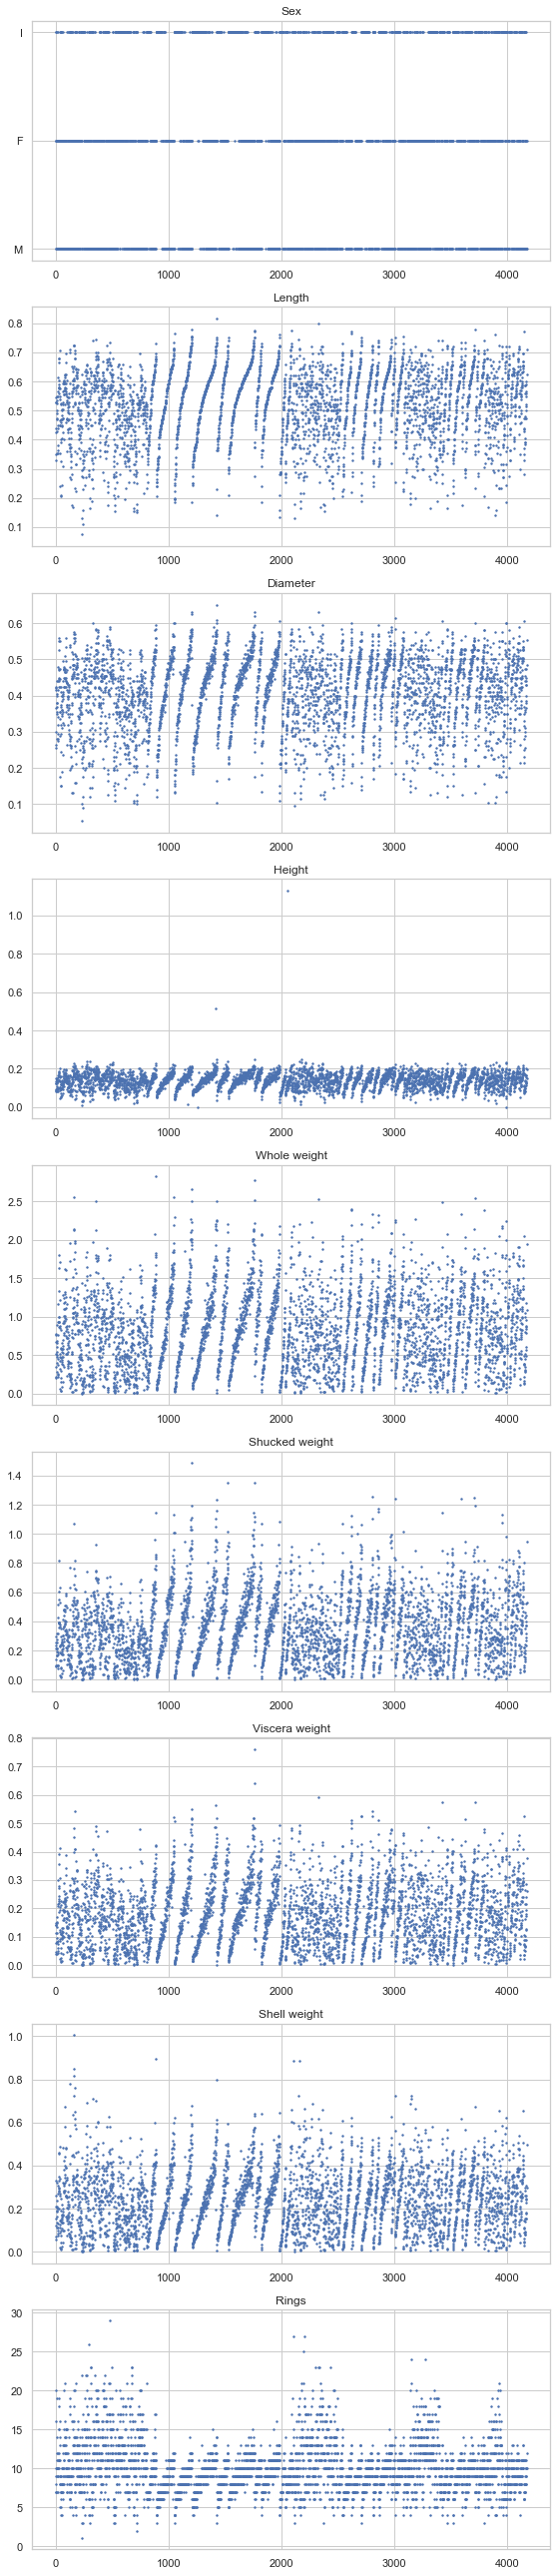

In [201]:
def visualizeData(df):
    x = [_ for _ in range(len(df))]
    n_plots = df.shape[1]
    fig, axs = plt.subplots(n_plots,1,figsize=(8, 4 * n_plots),tight_layout=True)
    for c,col in enumerate(df.columns):
        col_name = df.columns[c]
        y = df.iloc[:,c]
        axs[c].scatter(x, y, s=2)
        axs[c].set_title(col_name)
    plt.show()

visualizeData(df)

## Removing outliers: the naive way

By observation, we have 2 outlier height values. We will remove those 2 rows containing the outlier height values to prevent errors during data normalization. We can do this because it is a very small fraction of data lost and should not have a significant impact on the outcome of the model.\
Now we have no outliers in height.

Length of dataframe before removal of outliers: 4174
Length of dataframe after removal of outliers: 4174


Text(0.5, 1.0, 'Height')

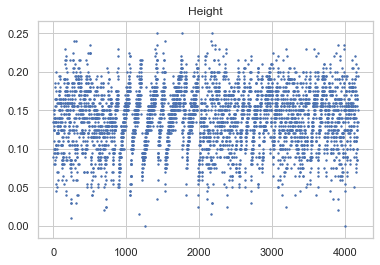

In [207]:
print(f'Length of dataframe before removal of outliers: {len(df)}')
df = df[df['Height'] < 0.5]
print(f'Length of dataframe after removal of outliers: {len(df)}')
x_ = [_ for _ in range(len(df))]
y_ = df.iloc[:,3]
plt.scatter(x_,y_, s=2)
plt.title('Height')

## Explore the distribution of the number of rings for infants, males and females.

Here we make our first significant observation: Infants have less rings than male or female abalone, suggesting that whether or not an abalone is an infant or not is indicative of the number of rings, and therefor can be used as an estimator for the age.

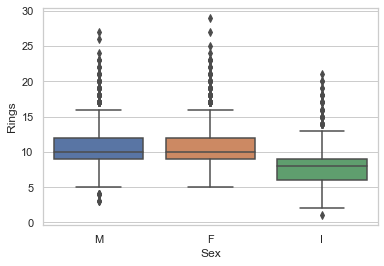

In [55]:
sns.set(style="whitegrid")
ax1 = sns.boxplot(x="Sex", y="Rings", data=df)

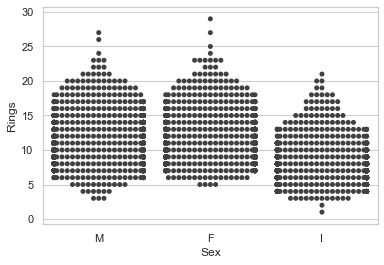

In [56]:
ax2 = sns.swarmplot(x="Sex", y="Rings", data=df, color=".25")

## Use a correlation matrix to explore the correlation coefficients between variables.

We're most interested in the correlation value between the rings and the other measurements. All the correlation values are similar, however shell weight provides the highest correlation value. This could indicate the abalones with larger shell weights are older. In order to determine the shell weight however, the abalone must be shucked, and ideally, we'd like to avoid shucking the abalone all together.

If we look at height however, this is a measurement which is more easily taken, and has a correlation value of 0.02 less than shell weight. Measuring the abalone height is an easier way to estimate the age of the abalone without having to weigh the shell, and is less invasive on the abalone specimen.

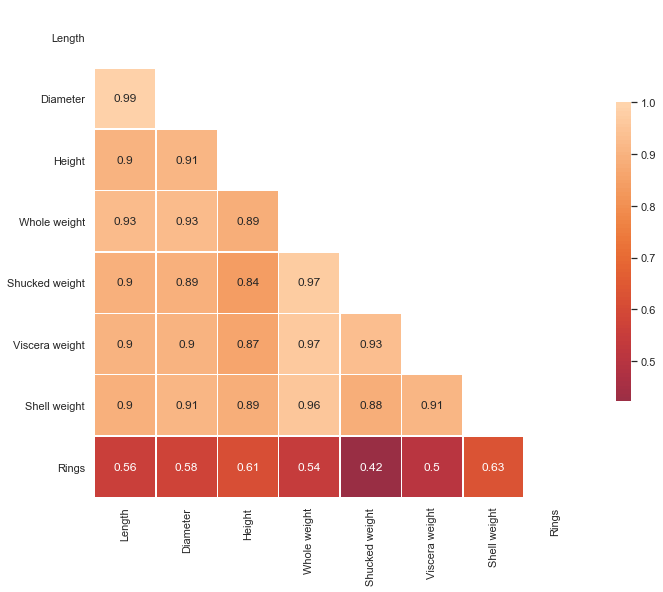

In [57]:
corr = df.corr() # Compute the correlation matrix
mask = np.triu(np.ones_like(corr,dtype=bool)) # Generate a mask for the upper triangle
f1, a1 = plt.subplots(figsize=(11, 11))
sns.heatmap(corr, mask=mask, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

## Facetgrids for data exploration

Here we map each feature onto the axes and compare the level (amount) of each variable with relation to the gender. We observe that the plots with facetgrids which are most similar to that of the "Rings" facetgrid have a higher correlation with the number of rings. This is another way to visualize which features can be used to estimate the age of the abalone.

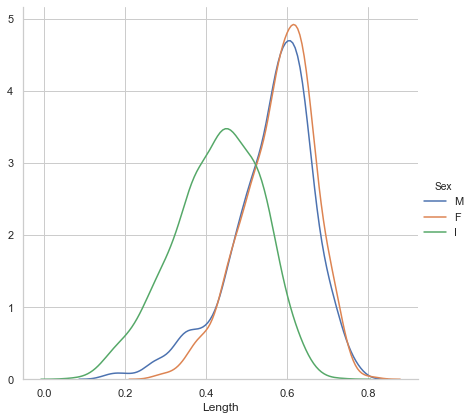

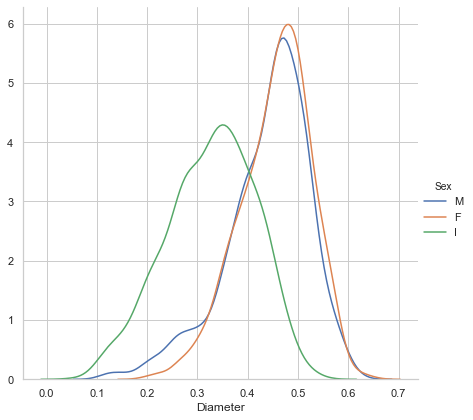

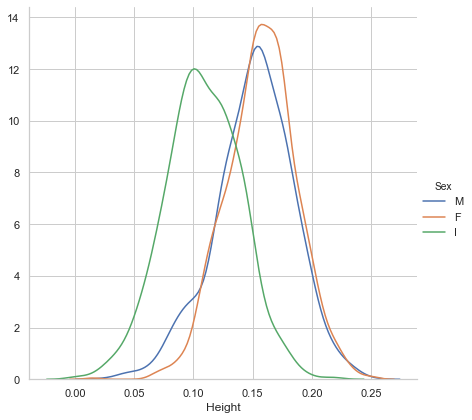

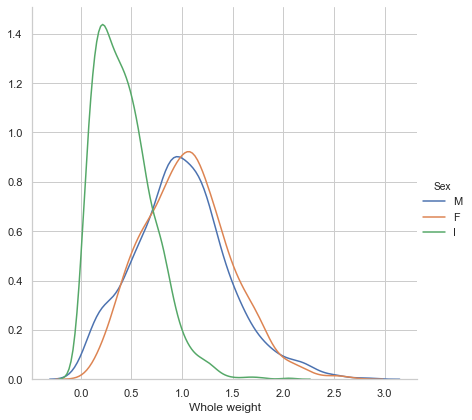

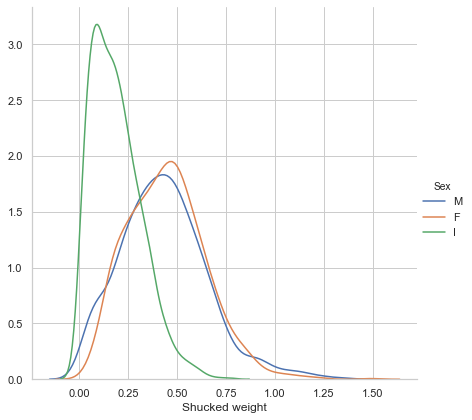

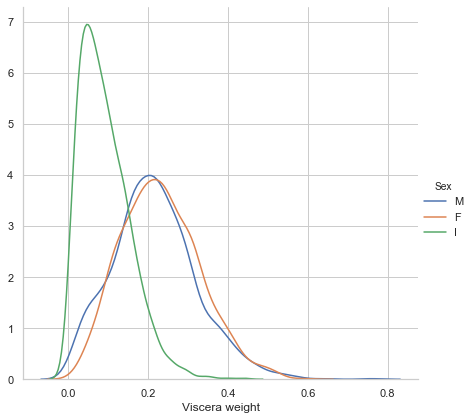

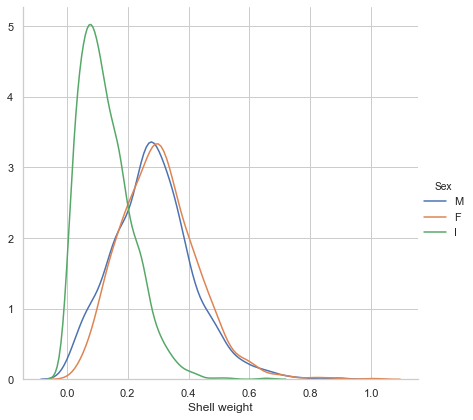

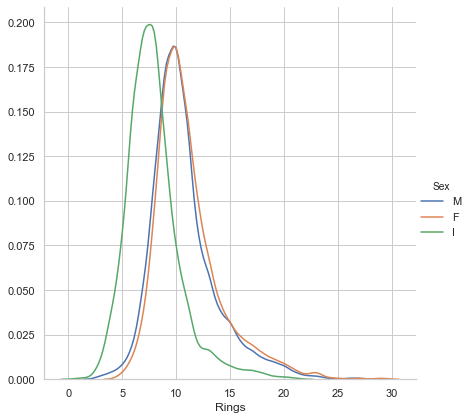

In [58]:
for col in df.columns:
    if col!='Sex':
        colname = str(col)
        sns.FacetGrid(df, hue="Sex", height=6).map(sns.kdeplot, colname).add_legend()

# Final data preprocessing before modelling

### Turn gender into numeric values

In [190]:
le = preprocessing.LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
print(df.iloc[:,0].head(5))

0    2
1    0
2    2
3    1
4    1
Name: Sex, dtype: int32


### Normalize the data to a unit scale

In [194]:
# Don't want to noramlize rings, since this gives us the actual age of the abalone
cols_to_norm = ['Length','Diameter','Height','Whole weight','Shucked weight','Viscera weight','Shell weight',]
df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Models and comparison

Before we continue, we define 4 helper functions:

1st helper function is a loss function to compare the integer value of the output prediction of a certain model. The function was obtained from the following link: https://github.com/keras-team/keras/issues/2221. According to the author: the loss function "does have a derivative and that derivative is equal to a difference to target integer number." This will be used in the neural network.

In [180]:
def mean_rounding_loss(ytrue,ypred): #has derivative, that is equal to the nearest positive natural number
    x = ytrue-ypred
    a = np.round(np.abs(x))
    return np.abs(np.mean(a*(a-1)/4+a*x))
            
def comparePredictions(predictions):
    for i,p in enumerate(predictions):
        print(f'Predicted = {p} ----- Actual = {yt[i]}')
        if i==10:
            break
            
def offBy(predictions): # Generates a dictionary for the difference between predicted and actual
    d = {}
    for i,p in enumerate(predictions):
        diff = np.abs(p - yt[i])
        if diff not in d:
            d[diff] = 1
        else:
            d[diff] += 1
    return d

def offBy_visual(d, title): # Creates a bar chart for the dictionary
    lists = sorted(d.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.barh(x, y)
    plt.title(title)
    plt.xlabel('Frequency')
    plt.ylabel('Difference in number of rings')
    for index, value in enumerate(y):
        plt.text(value, index, str(value))

## Logistic regression

Logistic regression achieves a low validation accuracy of 25%, a high mean squared error of 6.9.\
This being said however, logistic regression performs well in estimating the age of an abalone. Out of 418 samples. 331 (79%) were within 3 rings, 260 (62%) were within 2, 154 (36%) were off by 1 and 106 were correctly predicted.
These values are relatively accurate predictors, as the average number of rings in the test set was 9, and the maximum number of rings was 23.

In [181]:
accuracies = []
mses = []
for _ in range(100):
    lr = LogisticRegression(multi_class='ovr', solver='newton-cg', max_iter=2000, random_state=17) # ovr: one versus rest
    lr.fit(x_train, y_train)
    accuracies.append(lr.score(x_test, y_test))
    mses.append(mean_squared_error(lr.predict(x_test), np.array(y_test)))

print(f'Logistic regression achieved a maximum validation accuracy of {max(accuracies)}')
print(f'Logistic regression achieved an average validation accuracy of {np.mean(accuracies)}')
print(f'Logistic regression achieved a minimum mean squared error of of {min(mses)}')
print(f'Logistic regression achieved an average mean squared error of of {np.mean(mses)}')

Logistic regression achieved a maximum validation accuracy of 0.2535885167464115
Logistic regression achieved an average validation accuracy of 0.25358851674641153
Logistic regression achieved a minimum mean squared error of of 6.966507177033493
Logistic regression achieved an average mean squared error of of 6.966507177033492


Average number of rings for the abalones in test sample: 9.885167464114833
 maximum number of rings: 23


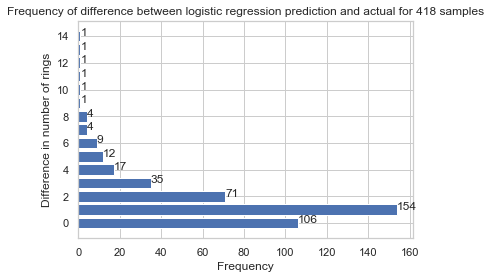

In [182]:
nr_abalones = len(y_test)
avg_rings, max_rings = np.mean(y_test), max(y_test)
print(f'Average number of rings for the abalones in test sample: {avg_rings}\n maximum number of rings: {max_rings}')

lr = LogisticRegression(multi_class='ovr', solver='newton-cg', max_iter=2000, random_state=17) # ovr: one versus rest
lr.fit(x_train, y_train)

l_preds = lr.predict(x_test)
yt = np.array(y_test)
d = offBy(l_preds)
t = 'Frequency of difference between logistic regression prediction and actual for '+str(nr_abalones)+' samples'
offBy_visual(d, t)

## K nearest neighbours

Performs very similarly to logistic regression given k=22 neighbours. Concretely, 341 (82%) predictions fall within 3 rings difference to the actual prediction, only 10 more than logistic regression. KNN also correctly predicted the number of rings for 3 abalone more than logistic regression. This is a slight improvement over logistic regression. But can we do better?

Best value for k is : 22
KNN achieved a maximum validation accuracy of 0.2607655502392344
KNN achieved an average validation accuracy of 0.2394785665462357
KNN achieved a minimum mean squared error of of 5.44976076555024
KNN achieved an average mean squared error of of 6.075725026852846


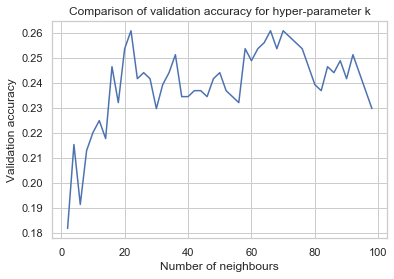

In [183]:
accuracies_mean = []
mses_mean = []
neighbours = range(2,100,2)
for i in neighbours:
    accuracies_j = []
    mses_j = []
    for j in range(4): # For each k, attempt knn 4 times. Output the mean of the 4 attempts .
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(x_train, y_train)
        accuracies_j.append(knn.score(x_test, y_test))
        mses_j.append(mean_squared_error(knn.predict(x_test), np.array(y_test)))
    accuracies_mean.append(np.mean(accuracies_j))
    mses_mean.append(np.mean(mses_j))

best_k = 2*accuracies_mean.index(max(accuracies_mean))+2 # Since we started at 2, incremented by 2 each time in the for loop
plt.plot(neighbours, accuracies_mean)
plt.xlabel('Number of neighbours')
plt.ylabel('Validation accuracy')
plt.title('Comparison of validation accuracy for hyper-parameter k')
print(f'Best value for k is : {best_k}')
print(f'KNN achieved a maximum validation accuracy of {max(accuracies_mean)}')
print(f'KNN achieved an average validation accuracy of {np.mean(accuracies_mean)}')
print(f'KNN achieved a minimum mean squared error of of {min(mses_mean)}')
print(f'KNN achieved an average mean squared error of of {np.mean(mses_mean)}')

Average number of rings for the abalones in test sample: 9.885167464114833
 maximum number of rings: 23


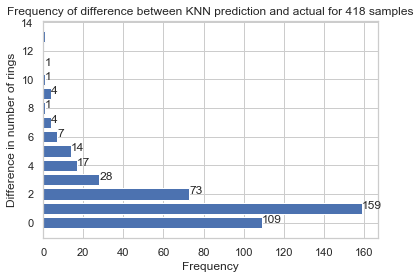

In [184]:
print(f'Average number of rings for the abalones in test sample: {avg_rings}\n maximum number of rings: {max_rings}')

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)

k_preds = knn.predict(x_test)
yt = np.array(y_test)
d = offBy(k_preds)
t = 'Frequency of difference between KNN prediction and actual for '+str(nr_abalones)+' samples'
offBy_visual(d, t)

## Deep neural network

In summary, the neural networks are less prone to major errors in estimating age. The spread for the difference between the model prediction and the actual age is smaller (10 instead of 14).\
Additionally, the best neural network architecture found provides a much lower mean squared error value compared to KNN and logistic regression. 355 (85%) of abalone fall within 3 rings away from the actual number of rings provided, however only 109 (26%) abalone samples were predicted correctly, which is the same as KNN.

### Create a train/test split

In [134]:
Y = df.iloc[:,-1]   # age[i] = rings[i] + 1.5, Y:rings
X = df.iloc[:,0:-2]
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, random_state=44)

## Here, we will use KerasTuner to perform a randomsearch for the best hyper-parameters for our neural network.

### Hyper-parameters:
1: Number of hidden layers\
2: Number of neurons in each layer\
3: Learning rate for our optimizer during network compilation

In [7]:
def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(Dense(256, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))

    # Fully connected layers
    for i in range(hp.Int('num_layers', 2, 5)): # We want maximum 2-5 layers, decided from previous trial/error
        model.add(Dense(
            units=hp.Int('units_' + str(i), min_value=256, max_value=1048, step=256),
            activation='swish'
        ))
        model.add(Dropout(
            rate=hp.Float('dropout_'+str(i), min_value=0.0, max_value=0.4, default=0.1, step=0.1) 
        ))
    
    # Output layer: "for linear regression type of problem, create the Output layer without activation fn--> numerical values without any transformation.""
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Test out different learning rates for Adam
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [0.001, 0.003, 0.005])),
        loss='mean_absolute_error',
        metrics=['mse'])
    
    return model
    
tuner = RandomSearch(
    build_model,
    objective='val_mse',
    max_trials=15,
    executions_per_trial=4,
    directory='proj',
    project_name='models')

tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 5, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1048, 'step': 256, 'sampling': None}
dropout_0 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 256, 'max_value': 1048, 'step': 256, 'sampling': None}
dropout_1 (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.003, 0.005], 'ordered': True}


In [8]:
tuner.search(
    x=x_train,
    y=y_train,
    validation_data=(x_test, y_test),
    epochs=50, # Reduced number of epochs.
)

Trial 15 Complete [00h 02m 02s]
val_mse: 3.607939839363098

Best val_mse So Far: 3.5837194323539734
Total elapsed time: 00h 29m 02s
INFO:tensorflow:Oracle triggered exit


In [210]:
# ================== Uncomment the code below to obtain the summary of the top 10 best neural networks ==================
# tuner.results_summary()

## Top 3 models based on KerasTuner RandomSearch

### First:
units_0: 1024\
dropout_0: 0.4\
units_1: 768\
dropout_1: 0.4\
learning_rate: 0.001\
units_2: 768\
dropout_2: 0.1\
units_3: 1024\
dropout_3: 0.2\
Score: 3.5837194323539734


### Second:
units_0: 768\
dropout_0: 0.1\
units_1: 256\
dropout_1: 0.30000000000000004\
learning_rate: 0.001\
units_2: 768\
dropout_2: 0.30000000000000004\
units_3: 768\
dropout_3: 0.1\
Score: 3.5925803184509277


### Third:
units_0: 512\
dropout_0: 0.1\
units_1: 512\
dropout_1: 0.0\
learning_rate: 0.001\
units_2: 1024\
dropout_2: 0.0\
units_3: 768\
dropout_3: 0.1\
Score: 3.596859395503998

### Now, we create 2 neural networks. 1 which follows the keras-tuner, and another which is a slight variation to see if we can extract additional performance.

In [195]:
def create_cnn_1(): # Based off keras-tuner
    model = Sequential()
    model.add(Dense(256, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1024, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(768, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(768, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    return model

cnn1 = create_cnn_1()
model1 = Model(inputs=cnn1.inputs, outputs = cnn1.outputs)
model1.compile(
    optimizer=Adam(lr=0.001),
    loss='mean_absolute_error',
    metrics=['mse'])
model1.summary()
model1.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=100,
    verbose=0
)
_,mse1 = model1.evaluate(x_test,y_test)
print(f'The mean squared error for model 1 is: {acc1}')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35_input (InputLayer)  [(None, 7)]               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               2048      
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1024)              263168    
_________________________________________________________________
dropout_24 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 768)               787200    
_________________________________________________________________
dropout_25 (Dropout)         (None, 768)               0   

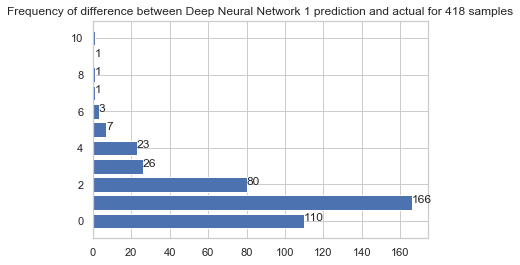

In [179]:
preds = model1.predict(x_test)
preds = np.array([int(np.round(p[0])) for p in preds])
yt = np.array(y_test)
d = offBy(preds)
t = 'Frequency of difference between Deep Neural Network 1 prediction and actual for '+str(nr_abalones)+' samples'
offBy_visual(d, t)

In [196]:
def create_cnn_2(): # Modified version of the keras-tuners' model
    model = Sequential()
    model.add(Dense(256, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(768, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(768, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(1024, kernel_initializer='normal', input_dim = x_test.shape[1], activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    return model

cnn2 = create_cnn_2()
model2 = Model(inputs=cnn2.inputs, outputs = cnn2.outputs)
model2.compile(
    optimizer=Adam(lr=0.001),
    loss='mean_absolute_error',
    metrics=['mse'])
model2.summary()
model2.fit(
    x_train,
    y_train,
    batch_size=16,
    epochs=100,
    verbose=0
)
_,mse2 = model1.evaluate(x_test,y_test)
print(f'The mean squared error for model 2 is: {acc2}')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41_input (InputLayer)  [(None, 7)]               0         
_________________________________________________________________
dense_41 (Dense)             (None, 256)               2048      
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 768)               197376    
_________________________________________________________________
dropout_28 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 768)               590592    
_________________________________________________________________
dropout_29 (Dropout)         (None, 768)               0   

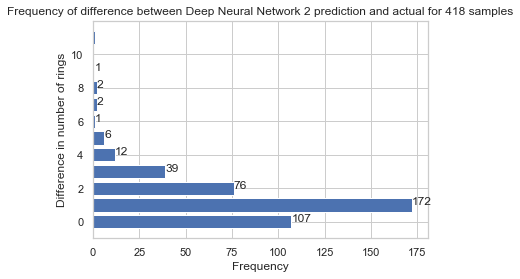

In [193]:
preds = model2.predict(x_test)
preds = np.array([int(np.round(p[0])) for p in preds])
yt = np.array(y_test)
d = offBy(preds)
t = 'Frequency of difference between Deep Neural Network 2 prediction and actual for '+str(nr_abalones)+' samples'
offBy_visual(d, t)